<a href="https://colab.research.google.com/github/sherifmost/face-recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About the project**

This is a project in the information systems and software course. Our objective is to perform face recognition on the ORL dataset and test its accuracy using PCA and LDA along with KNN classifiers.

# **About the data**

We used the ORL data set for face recognition, which contains 40 different subjects with 10 images each. Each image is a 92x112 image in PGM (Portable Gray Map) format. Images are classified by being placed in different directories; where those in folder sx belong to subject number x(x between 1 and 40). An image for a certain subject is named Y.pmg where Y is the image number (between 1 and 10).
Credits to: *AT&T Laboratories Cambridge* for providing the data.

# **Needed library imports**

In [1]:
from google.colab import drive
# used to manipulate the folders containing the images and read them out
import os
import matplotlib.image as mpimg 
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as lg 
from sklearn.neighbors import KNeighborsClassifier

# **Labels and constants**

In [2]:
# file paths
path_data = '/content/drive/My Drive/Information systems/Assignment 1/Data set';

# symbols
delim = '/';

# image dimensions
image_len = 92;
image_width = 112;

# constant numbers
training = 1;
testing = -1;
num_subjects = 40;

# **Helper functions**

## Helper functions for manipuating data

In [3]:
# functions used as keys for sort function
def numeric_key_folders(x):
  return int(x[1:]);
def numeric_key_images(x):
  # we want to get the number till .pmg so remove last 4 characters from the string considered
  return int(x[0:(len(x)-4)]);

## Helper functions for multiclass LDA dimensionality reduction

In [4]:
# function calculates the class means (mean of each class) given an array containing the number of samples per class (assuming the data matrix is sorted accordingly)
def get_class_means(D,num_samples):
  means = [];
  # keep the begining of the class from which the mean is calculated
  class_begin = 0;
  for curr_num in num_samples:
    curr_num = int(curr_num);
    means.append(np.mean(D[class_begin : class_begin + curr_num,:],axis = 0));
    class_begin = class_begin + curr_num;
  return np.array(means);
# function that calculates the S_b matrix given the number of samples for each class, the class means and the overall mean
def get_S_b(num_samples,class_means):
  # calculating the overal sample mean
  overal_mean = np.mean(class_means,axis = 0);
  # S_b has dimensions same as B which are d x d (where d is number of dimensions which is same as shape of the image after flattening)
  S_b = np.zeros(shape = (overal_mean.shape[0],overal_mean.shape[0]));
  # looping to calculate S_b
  for i in range(0,num_samples.shape[0]):
    S_b = S_b + num_samples[i] * np.dot((class_means[i,:] - overal_mean).reshape(overal_mean.shape[0],1),(class_means[i,:] - overal_mean).reshape(1,overal_mean.shape[0]));
  return S_b;
# function that centers the data given the data matrix, the class means and number of samples per class
def get_data_centered(D,num_samples,class_means):
  data_centered = [];
  class_begin = 0;
  mean_location = 0; 
  for curr_num in num_samples:
    curr_num = int(curr_num);
    data_centered.append(D[class_begin : class_begin + curr_num,:] - class_means[mean_location,:]);
    mean_location = mean_location + 1;
    class_begin = class_begin + curr_num;
  return np.array(data_centered).reshape(D.shape[0],D.shape[1]);
# function that obtains S matrix given the centered data and the number of samples per class
def get_S(D_centered,num_samples):
  S = np.zeros(shape = (D_centered.shape[1],D_centered.shape[1]));
  class_begin = 0;
  for curr_num in num_samples:
    curr_num = int(curr_num);
    S = S + D_centered[class_begin : class_begin + curr_num].T @ D_centered[class_begin : class_begin + curr_num];
    class_begin = class_begin + curr_num;
  return S;
# function given a matrix returns the n dominant eigen vectors
def get_dom_eig_vec(mat,n):
  # Getting eigen values and eigen vectors
  # As we don't know whether mat is symmetric or not, eig is used.
  eig_val,eig_vec = lg.eig(mat);
  # As dominant eigen vectors should be taken according to the magnitude of eigen values 
  # (as negative values only indicate reverse of the vector direction), we should consider the
  # absolute value of the eigen values.
  eig_val = np.absolute(eig_val);
  # using argsort to get dominant eigen vectors according to largest eigen values
  sorted_indecies = eig_val.argsort()[::-1];
  eig_vec = eig_vec[:,sorted_indecies];
  # when checking the results, eigen vectors may include imaginary parts.
  # we are only concerned with the real parts
  eig_vec = np.real(eig_vec);
  # getting first n dominant eigen vectors to be the proection matrix
  P = eig_vec[:,:n];
  return P;


## Helper functions for PCA dimensionality reduction

In [74]:
# this function obtains the reduced dimensions given eigen values and alpha
def get_dim_pca(eig_val,alpha):
  total = np.sum(eig_val);
  reduced_dim = 0;
  curr_sum = 0;
  for curr_val in eig_val:
    if curr_sum/total < alpha:
      curr_sum = curr_sum + curr_val;
      reduced_dim = reduced_dim + 1;
  return reduced_dim;

# **Obtaining the data and cleaning it**

In [5]:
# I uploaded the data to google drive as a zip file in order use it here
# Mounting the drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# unzipping the file, to be run only once
!unzip '/content/drive/My Drive/Information systems/Assignment 1/orl_dataset.zip' -d '/content/drive/My Drive/Information systems/Assignment 1/Data set'

## Reading the data to generate the data matrix and the label vector

In [6]:
def generate_data():
  # first obtaining the directories and sorting them
  subjects_dir = os.listdir(path_data);
  # Note that I manually removed the readme file from my drive after unzipping the data
  # sorting the directories to obtain the subjects' data sorted from 1 to 40
  subjects_dir.sort(key = numeric_key_folders);
  # converting the images to the flattened format and filling the D and Y matrices as required
  D = [];
  Y = [];
  flatten_dim = image_len * image_width;
  for current_dir in subjects_dir:
    current_label = numeric_key_folders(current_dir);
    subject_images = os.listdir(path_data + delim + current_dir);
    # sorting the images to obtain the current subject's images sorted from 1 to 10
    subject_images.sort(key = numeric_key_images);
    for current_image in subject_images:
      # image is reshaped to be flattened as a vector
      D.append(mpimg.imread(path_data + delim + current_dir + delim + current_image).reshape(flatten_dim));
      Y.append(current_label);
  return np.array(D), np.array(Y);

## splitting the data and labels to training and testing

In [7]:
# this function splits the data according to specified values to take which for training and which for testing.
# to get odd rows for training and even rows for testing, make train_each = test_each = 1 and start = testing (as matrices and vectors are 0 indexed).
def split_data(D,Y,train_each = 1,test_each = 1,start = testing):
  # flag checks whether data is in training or testing
  destination = start;
  # counter checks how many samples were taken
  taken = 0;
  D_train = [];
  Y_train = [];
  num_samples_train = np.array(np.zeros(num_subjects));
  D_test = [];
  Y_test = [];
  num_samples_test = np.array(np.zeros(num_subjects));
  for i in range(0, Y.shape[0]):
    taken = taken + 1;
    if destination == training:
      D_train.append(D[i,:]);
      Y_train.append(Y[i]);
      num_samples_train[Y[i] - 1] = num_samples_train[Y[i] - 1] + 1; 
      if taken == train_each:
        destination = testing;
        taken = 0;
    else:
      D_test.append(D[i,:]);
      Y_test.append(Y[i]);
      num_samples_test[Y[i] - 1] = num_samples_test[Y[i] - 1] + 1; 
      if destination == testing:
        destination = training;
        taken = 0;
  return np.array(D_train),np.array(Y_train),num_samples_train,np.array(D_test),np.array(Y_test),num_samples_test;    
        


# **Dimensionality reduction using LDA**

In [8]:
def reduce_lda(D_train,D_test,num_samples_train):
  # getting the class means for the training data
  means_class_train = get_class_means(D_train,num_samples_train);
  # getting S_b (which replaces the between-class scatter matrix B in case of multiclass LDA)
  S_b_train = get_S_b(num_samples_train,means_class_train); 
  # getting S using centered data and number of samples
  S_train = get_S(get_data_centered(D_train,n_train,means_class_train),n_train);
  # getting S^-1 * S_b
  # pinv is used to overcome numerical errors (by approximation)
  # when trying this, I found that results are not correct (numbers don't make sense) unless we identify the matrix to be 
  # hermitian which corresponds to the S matrix being symmetric by nature.
  mul_res_train = lg.pinv(S_train,hermitian = True) @ S_b_train;
  # getting the dominant m - 1 eigen vectors where m is number of classes as the projection matrix
  P = get_dom_eig_vec(mul_res_train,num_samples_train.shape[0] - 1);
  # finally we just return the data in reduced form
  return np.real(D_train @ P), np.real(D_test @ P);


# **Dimensionality reduction using PCA**

In [93]:
# This function obtains the eigen vectors ordered descendingly according to the corresponding eigen values.
# The output of this function can be used to obtain a projection matrix and perform dimensioonality
# reduction accordingly.
def get_eig_pca(D):
  # getting the mean of the samples
  mean = np.mean(D,axis = 0);
  # centering the data by subtracting the mean
  D_centered = D - mean;
  # computing the covariance matrix, specifying bias to be true in order to go along with the given pseudo code
  # ie: divide by n not n-1, also we get covariance of the transpose to follow the pseudo code (D.T @ D not the opposite)
  cov = np.cov(D_centered.T,bias = True);
  # as the covariance matrix is symmetric, we can use eigh with it to get the eigen vectors
  eig_val,eig_vec = lg.eigh(cov);
  # As dominant eigen vectors should be taken according to the magnitude of eigen values 
  # (as negative values only indicate reverse of the vector direction), we should consider the
  # absolute value of the eigen values.
  eig_val = np.absolute(eig_val);
  # sorting in descending order according to the eigenvalues
  sorted_indeces = eig_val.argsort()[::-1];
  return np.real(eig_vec[:,sorted_indeces]),np.real(eig_val[sorted_indeces]);

In [92]:
# This function outputs the reduced (projected) training and test data given the corresponding 
# eigen vectors sorted descendingly according to the corresponding eigen values as well as the 
# original traning and test data and finally the hyper parameter alpha.
def reduce_pca(D_train,D_test,eig_vec,eig_val,alpha):
  # first we get the projection matrix according to the given alpha and eigen vectors
  P = eig_vec[:,:get_dim_pca(eig_val,alpha)];
  return np.real(D_train @ P),np.real(D_test @ P);

# **Classification using KNN**

In [43]:
# given the train data, train labels, test data, test labels and number of neighbours 
# it returns the test accuracy using KNN with this number of neighbours.
# for the tie breaking, we decided to keep the default strategy.
# for weights we used distance as a parameter, so that the nearer the neighbour the more impact it has
# on the classification.
def classify_KNN(D_train,Y_train,D_test,Y_test,n_neigh = 1):
  classifier = KNeighborsClassifier(n_neighbors = n_neigh, weights = 'distance');
  classifier.fit(D_train,Y_train);
  acc_train = classifier.score(D_train, Y_train);
  acc_test = classifier.score(D_test, Y_test);
  return acc_train,acc_test;

# **Scripts used to run the function and give the required outputs**

## Generating the data

In [ ]:
# script to generate the data and split it giving odd rows for training and even rows for testing starting with testing (zero indexed).
D,Y = generate_data(); 
D_train,Y_train,n_train,D_test,Y_test,n_test = split_data(D,Y);

## Reporting accuracy for every alpha using PCA and first nearest neighbor

For alpha = {0.8,0.85,0.9,0.95} 

In [94]:
# obtaining the eigen vectors once to save computation time
eig_vec_pca,eig_val_pca = get_eig_pca(D_train);

In [95]:
# obtaining accuracies for different alphas using KNN with the first NN
alpha = [0.8,0.85,0.9,0.95];
acc_train_pca = [];
acc_test_pca = [];
print('Accuracy of PCA using first nearest neighbour:');
for curr_alpha in alpha:
  # obtaining the projected training and testing data
  D_train_reduced_pca,D_test_reduced_pca = reduce_pca(D_train,D_test,eig_vec_pca,eig_val_pca,curr_alpha);
  curr_acc_train,curr_acc_test = classify_KNN(D_train_reduced_pca,Y_train,D_test_reduced_pca,Y_test);
  acc_train_pca.append(curr_acc_train);
  acc_test_pca.append(curr_acc_test);
  print('For alpha: %.2f, dimensions reduced to: %d, with classification accuracy: training: %.2f%%, testing: %.2f%%' % (curr_alpha,D_train_reduced_pca.shape[1],curr_acc_train*100,curr_acc_test*100));


Accuracy of PCA using first nearest neighbour:
For alpha: 0.80, dimensions reduced to: 37, with classification accuracy: training: 100.00%, testing: 93.00%
For alpha: 0.85, dimensions reduced to: 53, with classification accuracy: training: 100.00%, testing: 94.00%
For alpha: 0.90, dimensions reduced to: 77, with classification accuracy: training: 100.00%, testing: 94.50%
For alpha: 0.95, dimensions reduced to: 116, with classification accuracy: training: 100.00%, testing: 93.50%


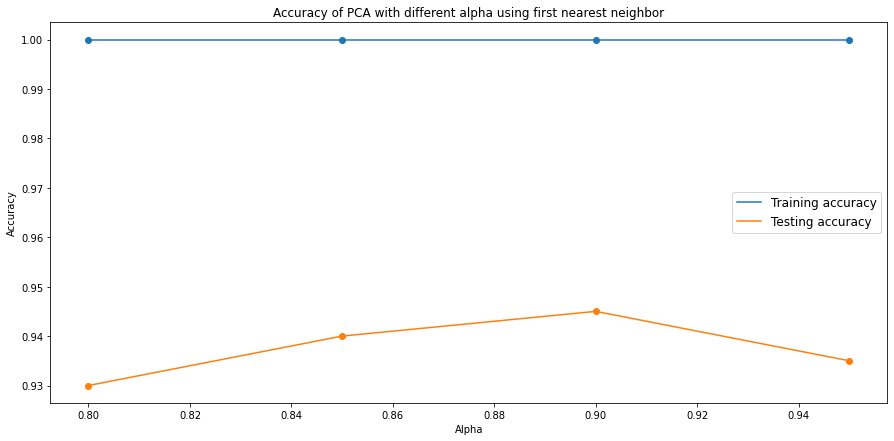

In [96]:
# plotting the training and testing accuracies with different alphas
plt.figure(figsize=(15,7));
plt.plot(alpha, acc_train_pca, label = 'Training accuracy');
plt.plot(alpha, acc_test_pca, label = 'Testing accuracy');
plt.scatter(alpha, acc_train_pca);
plt.scatter(alpha, acc_test_pca);
plt.legend(loc='center right',fontsize='large');
plt.xlabel('Alpha');
plt.ylabel('Accuracy');
plt.title('Accuracy of PCA with different alpha using first nearest neighbor')
plt.show();
plt.close();

As shown, when increasing alpha the accuracy increases till a certain alpha then starts dropping once more (this may be as KNN works better with lower dimensions or a mere coincidence as drop in accuracy isn't huge).However, the general relation seen is that accuracy increases with increasing alpha.

## Reporting accuracy for LDA using first nearest neighbor

In [11]:
# script to perform the LDA reduction
D_train_reduced_lda,D_test_reduced_lda = reduce_lda(D_train,D_test,n_train);

In [77]:
# script to get the KNN accuracy for LDA using first NN
acc_train_lda,acc_test_lda = classify_KNN(D_train_reduced_lda,Y_train,D_test_reduced_lda,Y_test);
print('Accuracy of LDA using first nearest neighbour:');
print('Training: %.2f%%, Testing: %.2f%%' % (acc_train_lda*100,acc_test_lda*100));

Accuracy of LDA using first nearest neighbour:
Training: 100.00%, Testing: 96.00%


## Comparing results of LDA and PCA

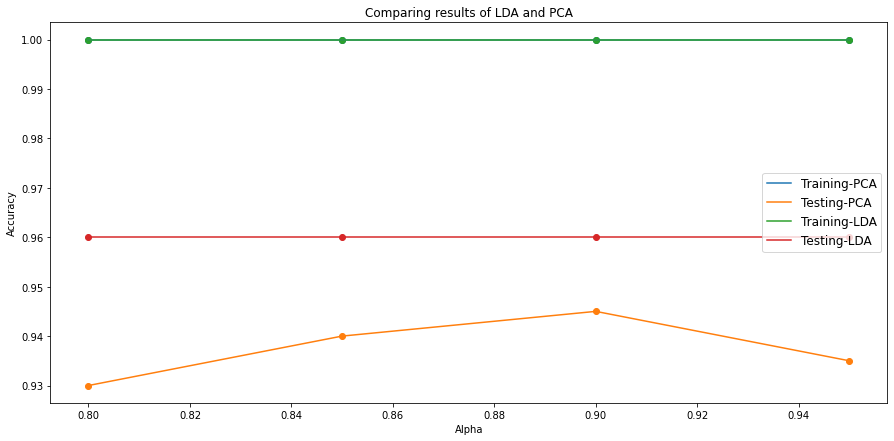

In [100]:
# plotting the training and testing accuracies for both LDA and pca (plotted against alpha to compare all possible accuracies)
plt.figure(figsize=(15,7));
plt.plot(alpha, acc_train_pca, label = 'Training-PCA');
plt.plot(alpha, acc_test_pca, label = 'Testing-PCA');
plt.scatter(alpha, acc_train_pca);
plt.scatter(alpha, acc_test_pca);
plt.plot(alpha, np.repeat(acc_train_lda,len(alpha)), label = 'Training-LDA');
plt.plot(alpha, np.repeat(acc_test_lda,len(alpha)), label = 'Testing-LDA');
plt.scatter(alpha, np.repeat(acc_train_lda,len(alpha)));
plt.scatter(alpha, np.repeat(acc_test_lda,len(alpha)));
plt.legend(loc='center right',fontsize='large');
plt.xlabel('Alpha');
plt.ylabel('Accuracy');
plt.title('Comparing results of LDA and PCA')
plt.show();
plt.close();

As seen, both LDA and PCA give an accuracy of 100% for training data, but LDA gives better accuracy for classification of testing data (higher than highest reported PCA accuracy for different alphas).

## Classifier tuning

number of neighbors in KNN should be set to:
1,3,5,7.

In [101]:
n_neigh = [1,3,5,7];

### For PCA

Accuracy of PCA using 1 nearest neighbour:
For alpha: 0.80, dimensions reduced to: 37, with classification accuracy: training: 100.00%, testing: 93.00%
For alpha: 0.85, dimensions reduced to: 53, with classification accuracy: training: 100.00%, testing: 94.00%
For alpha: 0.90, dimensions reduced to: 77, with classification accuracy: training: 100.00%, testing: 94.50%
For alpha: 0.95, dimensions reduced to: 116, with classification accuracy: training: 100.00%, testing: 93.50%
Accuracy of PCA using 3 nearest neighbour:
For alpha: 0.80, dimensions reduced to: 37, with classification accuracy: training: 100.00%, testing: 91.00%
For alpha: 0.85, dimensions reduced to: 53, with classification accuracy: training: 100.00%, testing: 90.50%
For alpha: 0.90, dimensions reduced to: 77, with classification accuracy: training: 100.00%, testing: 90.50%
For alpha: 0.95, dimensions reduced to: 116, with classification accuracy: training: 100.00%, testing: 89.50%
Accuracy of PCA using 5 nearest neighbou

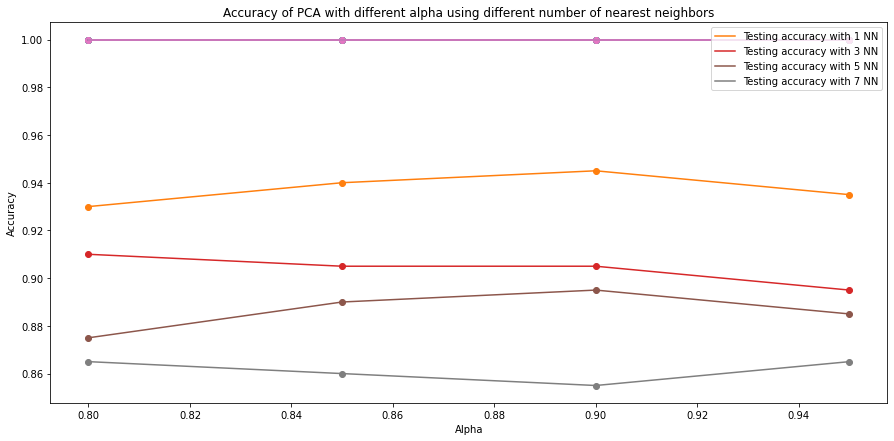

In [110]:
# obtaining accuracies for different alphas using KNN with different neighbours
alpha = [0.8,0.85,0.9,0.95];
plt.figure(figsize=(15,7));
for curr_n in n_neigh:
  acc_train_pca = [];
  acc_test_pca = [];
  print('Accuracy of PCA using %d nearest neighbour:'%(curr_n));
  for curr_alpha in alpha:
    # obtaining the projected training and testing data
    D_train_reduced_pca,D_test_reduced_pca = reduce_pca(D_train,D_test,eig_vec_pca,eig_val_pca,curr_alpha);
    curr_acc_train,curr_acc_test = classify_KNN(D_train_reduced_pca,Y_train,D_test_reduced_pca,Y_test,curr_n);
    acc_train_pca.append(curr_acc_train);
    acc_test_pca.append(curr_acc_test);
    print('For alpha: %.2f, dimensions reduced to: %d, with classification accuracy: training: %.2f%%, testing: %.2f%%' % (curr_alpha,D_train_reduced_pca.shape[1],curr_acc_train*100,curr_acc_test*100));
  plt.plot(alpha, acc_train_pca);
  plt.plot(alpha, acc_test_pca, label = 'Testing accuracy with {} NN'.format(curr_n));
  plt.scatter(alpha, acc_train_pca);
  plt.scatter(alpha, acc_test_pca);
plt.legend(loc='upper right',fontsize='medium');
plt.xlabel('Alpha');
plt.ylabel('Accuracy');
plt.title('Accuracy of PCA with different alpha using different number of nearest neighbors')
plt.show();
plt.close();

As found, best accuracy is when using first nearest neighbor.

### For LDA

Accuracy of LDA using 1 nearest neighbour:
Training: 100.00%, Testing: 96.00%
Accuracy of LDA using 3 nearest neighbour:
Training: 100.00%, Testing: 92.50%
Accuracy of LDA using 5 nearest neighbour:
Training: 100.00%, Testing: 93.00%
Accuracy of LDA using 7 nearest neighbour:
Training: 100.00%, Testing: 93.00%


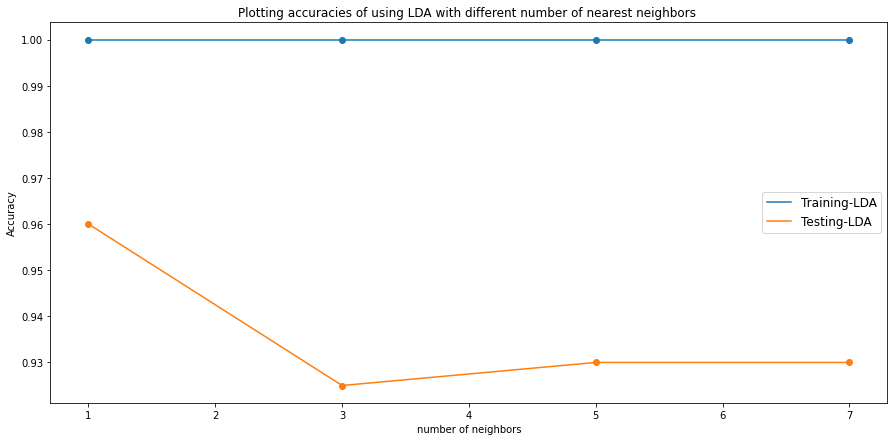

In [112]:
# script to get the KNN accuracy for LDA using different NN
acc_train_tot = [];
acc_test_tot = [];
for curr_n in n_neigh:
  acc_train_lda,acc_test_lda = classify_KNN(D_train_reduced_lda,Y_train,D_test_reduced_lda,Y_test,curr_n);
  acc_train_tot.append(acc_train_lda);
  acc_test_tot.append(acc_test_lda)
  print('Accuracy of LDA using %d nearest neighbour:'%(curr_n));
  print('Training: %.2f%%, Testing: %.2f%%' % (acc_train_lda*100,acc_test_lda*100));
# plotting the training and testing accuracies for LDA with different NN values
plt.figure(figsize=(15,7));
plt.plot(n_neigh, acc_train_tot, label = 'Training-LDA');
plt.plot(n_neigh, acc_test_tot, label = 'Testing-LDA');
plt.scatter(n_neigh, acc_train_tot);
plt.scatter(n_neigh, acc_test_tot);
plt.legend(loc='center right',fontsize='large');
plt.xlabel('number of neighbors');
plt.ylabel('Accuracy');
plt.title('Plotting accuracies of using LDA with different number of nearest neighbors ')
plt.show();
plt.close();

As seen, the best case is obtained when using the first nearest neighbor.